In [35]:
import numpy as np
from tqdm import tqdm

# For numericaly simulations:
import torch
use_cuda = True
if torch.cuda.is_available() and use_cuda:
    device = torch.device('cuda')
    print("Use cuda.")
else:
    device = torch.device('cpu')
    print("Use cpu.")
to_dev = lambda arr: (torch.from_numpy(arr).to(device)
                       if type(arr) == np.ndarray else arr.to(device))
# Low-rank RNN model
from rnn_model_dt_low_rank import RNN_Net_lr

# Nonlinearity
nonlin_str = 'erf'
if nonlin_str == 'tanh':
    nonlin = torch.nn.Tanh()
elif nonlin_str == 'erf':
    alpha_phi = np.sqrt(np.pi) / 2
    nonlin = lambda x: torch.special.erf(alpha_phi * x)
    
# Figures 
from specs import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

Use cpu.


In [18]:
# Model parameters
N_show = 256
lam_m_show = -5
lam_ps_sim = np.array([1.7, 1.9, 2.6])
n_lp_sim = len(lam_ps_sim)

z_target = 1
var_noise = 1.
lam_p_min = np.sqrt(1 + 2 * alpha_phi**2 * var_noise)


def L_var_erf(N, lam_p, lam_m, var_noise, z_target):
    kappa_sq = (lam_p**2 - lam_p_min**2) / (2 * alpha_phi**2)
    rho = z_target / (np.sqrt(N * kappa_sq))
    L_var = var_noise * (
        rho**2 * lam_p**2 / (lam_p**2 - lam_p_min**2)
        + rho**2 * var_noise * alpha_phi**2 / (3 * lam_p**2 - lam_p_min**2)
        + (1 - rho**2) * 1 / (1 - lam_m / lam_p)
    )
    return L_var

lam_p_max = lam_p_min + 1
lam_ps = np.linspace(lam_p_min+1e-2, lam_p_max, 501)
Ns = 2**np.arange(6, 15)
lam_ms = np.array([-1, -2, -5])


# Mean field
kappa_norms = np.sqrt((lam_ps**2 - lam_p_min**2) / (2 * alpha_phi**2))
rhos = z_target / (np.sqrt(Ns[:, None]) * kappa_norms)
    
L_vars = L_var_erf(Ns[:, None, None], lam_ps[None, None, :], lam_ms[None, :, None], var_noise, z_target)

lam_opt = lam_ps[np.argmin(L_vars, axis=-1)]
kappa_sq_opt = (lam_opt**2 - lam_p_min**2) / (2 * alpha_phi**2)
rho_opt = z_target / (np.sqrt(Ns[:, None] * kappa_sq_opt))

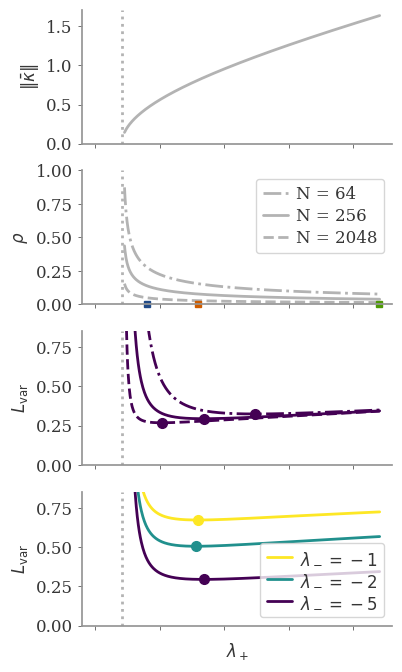

In [19]:
n_rows = 4
n_cols = 1
fig = plt.figure(figsize=(4 * n_cols, 2 * n_rows))
axes = subplots(fig, n_rows, n_cols, sharex=True)
i_c = 0
n_r_L = n_rows 

# Kappa norm
i_r = 0
c = c_leg
ax = axes[i_r, i_c]
ax.plot(lam_ps, kappa_norms, c=c)
ax.set_ylabel(r"$\|\bar{\kappa}\|$")
ax.set_ylim(0)

# Correlation
i_r = 1
ax = axes[i_r, i_c]
N_shows = np.array([64, 256, 2048])
mss = ["-.", "-", "--"]
i_show = np.where(N_shows[:, None] == Ns)[1]
for i in range(len(i_show)):
    ms = mss[i]
    i_N = i_show[i]
    y = rhos[i_N]
    ax.plot(lam_ps, y, ms, c=c, label="N = %d" % Ns[i_N])
ax.set_ylabel(r"$\rho$")
ax.set_ylim(0, 1)
ax.legend(loc=1, 
          labelspacing=0.3, handlelength=1.5, markerscale=1., 
        handletextpad=0.5, columnspacing=0.5, )

### Loss
from helpers import color_iterator
n_lam_m = len(lam_ms)
c_iter = color_iterator(n_lam_m, "viridis_r")
cs_L = np.array([c_iter(i) for i in range(n_lam_m)])
### For different N
i_r = 2
ax = axes[i_r, i_c]
i_lam_m = np.where(lam_ms == lam_m_show)[0][0]
c = cs_L[i_lam_m]
N_shows = np.array([64, 256, 2048])
mss = ["-.", "-", "--"]
i_show = np.where(N_shows[:, None] == Ns)[1]
for i in range(len(i_show)):
    ms = mss[i]
    i_N = i_show[i]
    y = L_vars[i_N, i_lam_m]
    ax.plot(lam_ps, y, ms, c=c, label="N = %d" % Ns[i_N])
    i_min = np.argmin(y)
    ax.plot(lam_ps[i_min], y[i_min], 'o', ms=7, c=c)
    
### For different lam_m
i_r = 3
ax = axes[i_r, i_c]
i_N = np.where(N_show == Ns)[0][0]
for i, lam_m_i in enumerate(lam_ms):
    i_lam_m = i
    c = cs_L[i_lam_m]
    y = L_vars[i_N, i_lam_m]
    ax.plot(lam_ps, y, c=c, label=r"$\lambda_-= %d$" % lam_m_i)
    i_min = np.argmin(y)
    ax.plot(lam_ps[i_min], y[i_min], 'o', ms=7, c=c)
ax.legend(loc=4, 
          labelspacing=0.3, handlelength=1.5, markerscale=1., 
        handletextpad=0.5, columnspacing=0.5, )

# Polish
for i_r in range(n_r_L):
    ax = axes[i_r, i_c]
    ax.axvline(lam_p_min, ls=':', c=c_leg,
               label=r"$\lambda_{+, \mathrm{min}}$" if i_r == 0 else None)
    ax.set_xlim(1.45, )
    
    if i_r in [2, 3]:
        ymax = L_vars[..., -1].max()*1.17
        ax.set_ylim(0, ymax)
        ax.set_ylabel(r"$L_\mathrm{var}$")
    
    if i_r == n_r_L-1:
        ax.set_xlabel(r"$\lambda_+$")
    else:
        ax.set_xticklabels([])
# Indicate the parameters for the second half
ax = axes[1, 0]
for i in range(n_lp_sim):
    ax.plot(lam_ps_sim[i], 0, 's', ms=5, c=colors[i], clip_on=False)


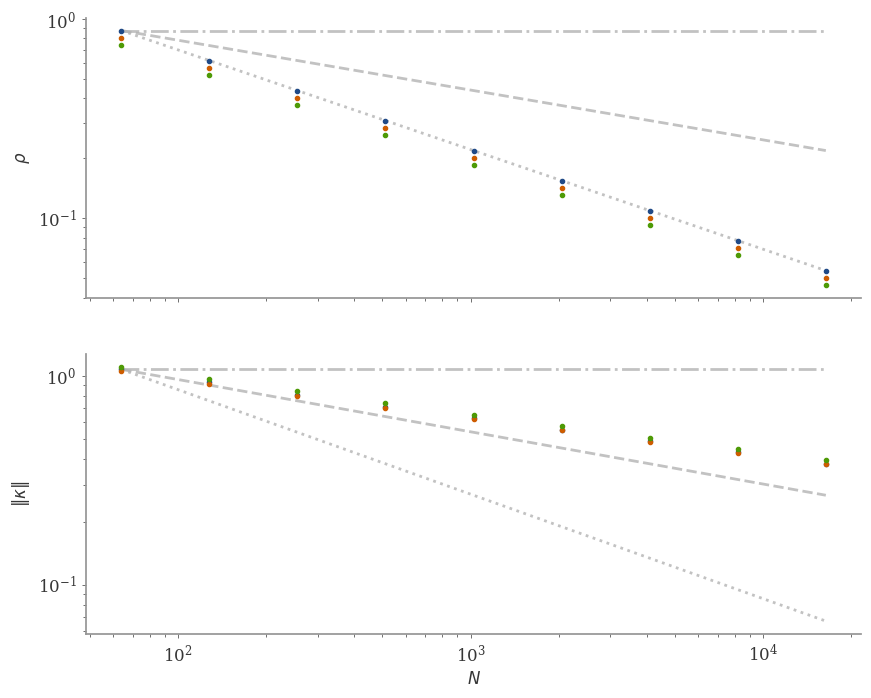

In [23]:
n_rows = 2
n_cols = 1
fig = plt.figure(figsize=(10 * n_cols, 4 * n_rows))
axes = subplots(fig, n_rows, n_cols, sharex=True)
# for i_r, i_c in np.ndindex(n_rows, n_cols):
i_c = 0

i_r = 0
ax = axes[i_r, i_c]
for i_r in range(n_rows):
    ax = axes[i_r, i_c]
    # ys = [rhos, np.sqrt(kappa_sq)][i_r]
    ys = [rhos, np.sqrt(kappa_sq_opt)][i_r]
    for i, lam_m in enumerate(lam_ms):
        i_lam_m = i
        c = colors[i_lam_m]
        y = ys[:, i_lam_m]
        ax.plot(Ns, y, 'o', c=c)
        if i == 0:
            ks = -np.array([0, 0.25, 0.5])
            lss = ['-.', '--', ':']
            c = c_leg
            for i_k, k in enumerate(ks):
                y_pow = Ns**k * (y[0] / Ns[0]**k)
                ls = lss[i_k]
                ax.plot(Ns, y_pow, ls, c=c, alpha=0.8, zorder=-1)
    ax.set_yscale("log")
    lbl = [r"$\rho$", r"$\|\kappa\|$"][i_r]
    ax.set_ylabel(lbl)

ax.set_xlabel(r"$N$")
ax.set_xscale("log")

In [24]:
from scipy.linalg import solve_lyapunov

# Nonlinearity
if nonlin_str == 'tanh':
    phi = lambda x: np.tanh(x)
    dphi = lambda x: 1 - phi(x)**2
    d2phi = lambda x: - 2 * phi(x) * dphi(x)
    d3phi = lambda x: - 2 * (d2phi(x) * phi(x) + dphi(x)**2)
elif nonlin_str == 'erf':
    from scipy.special import erf
    alpha_phi = np.sqrt(np.pi) / 2
    phi = lambda x: erf(alpha_phi * x)
    dphi = lambda x: np.exp(-(alpha_phi * x)**2)
    d2phi = lambda x: -2 * alpha_phi**2 * x * dphi(x)
    d3phi = lambda x: -2 * alpha_phi**2 * (dphi(x) + x * d2phi(x))
    d4phi = lambda x: -2 * alpha_phi**2 * (2 * d2phi(x) + x * d3phi(x))
    d5phi = lambda x: -2 * alpha_phi**2 * (3 * d3phi(x) + x * d4phi(x))
    int_phi = lambda x: x * phi(x) + 2 / np.pi * (dphi(x) - 1)
    int_Dx_Phi = lambda sigma_x: 2 / np.pi * (np.sqrt(1 + 2 * (alpha_phi * sigma_x)**2) - 1)
    def root_sigma_x_no_fp(sigma_x, sigma_noise, g):
        """ State amplitude sigma_x in absence of autonomous low-rank fixed point. """
        if g == 0:
            root_s = -sigma_x + sigma_noise
        elif sigma_noise == 0:
            int_Dx_phi_sq = avg_func(lambda x: phi(x)**2, sigma_x)
            root_s = -sigma_x**2 + g**2 * int_Dx_phi_sq
        else:
            int_Dx_Phi_sq = avg_func(lambda x: int_phi(x)**2, sigma_x)
            root_s = -sigma_x**4 + sigma_noise**4 + 2 * g**2 * (int_Dx_Phi_sq - int_Dx_Phi(sigma_x)**2)
        return root_s
    lam_p_sigma_x = lambda sigma_x: np.sqrt(1 + 2 * (alpha_phi * sigma_x)**2)
    sigma_x_lam_p = lambda lam_p: np.sqrt((lam_p**2 - 1) / 2) / alpha_phi
    
    def avg_Phi_dphi_func(sigma_x):
        return (
            2 / np.pi / np.sqrt(1 + 2 * (alpha_phi * sigma_x)**2) * (
            np.sqrt((1 + 4 * (alpha_phi * sigma_x)**2) / (1 + 2 * (alpha_phi * sigma_x)**2))
            - 1) )
    def f_Phi_dphi_func(c_0, c_inf, kappa_norm):
        return 2 / np.pi * (
        np.sqrt(
        (1 + 2 * alpha_phi**2 * (2 * kappa_norm**2 + c_0 + c_inf))
        * (1 + 2 * alpha_phi**2 * (c_0 - c_inf))
        ) / (1 + 2 * alpha_phi**2 * (kappa_norm**2 + c_0))
        - 
        1 / np.sqrt(1 + 2 * alpha_phi**2 * (kappa_norm**2 + c_0))
    ) 
    
    # Analytical expressions for averages (not very costly anyways...)
    avg_dphi_func = lambda sigma_x: 1 / np.sqrt(1 + 2 * (alpha_phi * sigma_x)**2)
    avg_d3phi_func = lambda sigma_x: -2 * alpha_phi**2 * (1 + 2 * (alpha_phi * sigma_x)**2)**(-3/2)
    avg_dphi_sq_func = lambda sigma_x: 1 / np.sqrt(1 + 4 * (alpha_phi * sigma_x)**2)
    avg_dphi_sq_p_phi_d2phi_func = lambda sigma_x: 1 / (1 + 2 * (alpha_phi * sigma_x)**2 ) * avg_dphi_sq_func(sigma_x)


# Mean field theory functions
from scipy.integrate import quad, dblquad
from scipy.optimize import root, root_scalar
# Averages
def avg_func(func, std):
    """ Average 'func' over Gaussian with standard dev. 'std'. """
    pdf = lambda z: np.exp(-z**2/2) / np.sqrt(2 * np.pi)
    return quad(lambda z: pdf(z) * func(std * z), -np.inf, np.inf)[0]
# Predict fixed point variance
def solve_sigma_x(avg_dphi, sigma_x_guess=1):
    x_target = avg_dphi
    func = lambda sigma_x: avg_func(dphi, sigma_x)
    root_log = lambda log_x: -x_target + func(np.exp(log_x))
    sol = root(root_log, x0=np.log(sigma_x_guess), method="hybr")
    if sol["success"]:
        log_sigma_x = sol["x"][0]
        sigma_x = np.exp(log_sigma_x)
        return sigma_x
    else:
        return 0.
    
# Noisy fixed point is shifted.
if nonlin_str == 'erf':
    def avg_dphi_func_root(norm_kappa, sigma_noise):
        return 1 / np.sqrt(1 + np.pi / 2 * (norm_kappa**2 + sigma_noise**2))
else:
    def avg_dphi_func_root(norm_kappa, sigma_noise):
        pdf = lambda z: np.exp(-z**2/2) / np.sqrt(2 * np.pi)
        integrand = lambda u, x: pdf(x) * pdf(u) * dphi(norm_kappa * u + sigma_noise * x)
        return dblquad(integrand, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf)[0]
def solve_norm_kappa_noisy(avg_dphi, sigma_noise, norm_kappa_guess=1):
    x_target = avg_dphi
    func = lambda norm_kappa: avg_dphi_func_root(norm_kappa, sigma_noise)
    root_log = lambda log_x: -x_target + func(np.exp(log_x))
    sol = root(root_log, x0=np.log(norm_kappa_guess), method="hybr")
    if sol["success"]:
        log_norm_kappa = sol["x"][0]
        norm_kappa = np.exp(log_norm_kappa)
        return norm_kappa
    else:
        return 0.

# Solve double integral equations numerically
def root_c_0_infty(cs, sigma_x, sigma_noise, g):
    c_0, c_inf = cs
    
    # Integrals
    gamma = 1 / np.sqrt(1 + 2 * alpha_phi**2 * (c_0 - c_inf) / sigma_x**2 * (2 * sigma_x**2 - (c_0 - c_inf)))
    beta = (sigma_x**2 - (c_0 - c_inf)) / sigma_x**2 * gamma
    f_phi_inf_0 = avg_func(
        lambda y: phi(sigma_x * y) * phi(sigma_x * beta * y), 1)
    sigma_hat = 1 / np.sqrt(1 + 2 * (alpha_phi * sigma_x * beta)**2)
    f_Phi_inf_0 = 2 / np.pi * (
        2 * alpha_phi**2 * (sigma_x**2 - (c_0 - c_inf)) * f_phi_inf_0
        + np.sqrt(1 + 2 * (alpha_phi * sigma_x)**2) * int_Dx_Phi(sigma_x * sigma_hat)
        - int_Dx_Phi(sigma_x)
    )
    f_Phi_0_0 = avg_func(lambda y: int_phi(y)**2, sigma_x)

    # Equations
    root_c_inf = -c_inf + g**2 * f_phi_inf_0
    root_c_0 = sigma_noise**4 - (c_0**2 - c_inf**2) + 2 * g**2 * (f_Phi_0_0 - f_Phi_inf_0)
    
    return np.array([root_c_inf, root_c_0])

# Constrain solutions to c_0 in [0, sigma_x**2], c_inf in [0, c_0]
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def inv_sigmoid(x):
    return np.log(x / (1 - x))
def root_c_0_infty_constr(arg_r_cs, sigma_x, sigma_noise, g):
    """ r_cs should both be in square [0, 1]. Force by using sigmoid. """
    r_cs = sigmoid(arg_r_cs)
    r_c_0, r_c_inf = r_cs
    c_0 = r_c_0 * sigma_x**2
    c_inf = r_c_inf * c_0
    cs = np.array([c_0, c_inf])
    return root_c_0_infty(cs, sigma_x, sigma_noise, g)
def solve_c_0_infty(sigma_x, sigma_noise, g, cs_init, c_0_min=0):
    if g == 0:
        cs = np.array([sigma_noise**2, 0.])
    elif sigma_noise == 0:
        c_0 = g**2 * avg_func(lambda x: phi(x)**2, sigma_x)
        cs = np.array([c_0, c_0])
    else:
        # Ratios in [0, 1]
        c_0, c_inf = cs_init

        c_0_max = sigma_x**2
        dc_0 = c_0_max - c_0_min
        assert c_0 >= c_0_min, "Initial guess too small for c_0"
        assert c_0 <= c_0_max, "Initial guess too large for c_0"
        r_c_0 = (c_0 - c_0_min) / dc_0

        c_inf_min = 0
        c_inf_max = c_0
        dc_inf = c_inf_max - c_inf_min
        assert c_inf >= c_inf_min, "Initial guess too small for c_inf"
        assert c_inf <= c_inf_max, "Initial guess too large for c_inf"
        r_c_inf = (c_inf - c_inf_min) / dc_inf

        r_cs_init = np.array([r_c_0, r_c_inf])
        # Expand to -oo, oo
        arg_r_cs_init = inv_sigmoid(r_cs_init)
        # Solve
        sol = root(root_c_0_infty_constr, x0=arg_r_cs_init, args=(sigma_x, sigma_noise, g), )
        if sol["success"]:
            arg_r_cs = sol["x"]
            r_cs = sigmoid(arg_r_cs)
            c_0 = r_cs[0] * dc_0 + c_0_min
            c_inf = r_cs[1] * dc_inf + c_inf_min
            cs = np.array([c_0, c_inf])
        else:
            cs = np.ones(2) * np.nan
    return cs

# Matrix M from EVs and angles
rank = 2
Id = np.eye(rank)
def comp_M(lam_p, lam_m, ang_wp, ang_wm, to_torch=False):
    """ Matrix from 4 arguments. Both angles relative to output w. """
    V = np.array([
        [np.cos(ang_wp), np.cos(ang_wm)],
        [np.sin(ang_wp), np.sin(ang_wm)],
        ])
    M = V @ np.diag(np.array([lam_p, lam_m])) @ np.linalg.inv(V)
    if to_torch:
        M = torch.from_numpy(np.float32(M))
        V = torch.from_numpy(np.float32(V))
    return M, V


def comp_MFT(lam_p, sigma_noise, g, cs_init=None):
    """ Compute Mean Field Theory prediction for given lam_p, sigma_noise, g.
    """
    # Critical EV
    sigma_x_crit_min = sigma_noise if g <= 1 else sigma_noise + 1e-5
    sigma_x_crit = root_scalar(root_sigma_x_no_fp, method='bisect', args=(sigma_noise, g), bracket=[sigma_x_crit_min, 10], x0=1.1).root
    lam_p_crit = lam_p_sigma_x(sigma_x_crit)
    
    # Norm of fixed point is entirely given by outlier
    sigma_x = sigma_x_lam_p(lam_p)
    # Norm of orthogonal component
    c_0_no_noise = g**2 * avg_func(lambda x: phi(x)**2, sigma_x)

    if lam_p > lam_p_crit and c_0_no_noise <= sigma_x**2:
        if cs_init is None:
            c_0_init = 0.5 * sigma_x
            c_inf_init = 0.4 * c_0_init
        else:
            c_0_init, c_inf_init = cs_init
        c_0_min = c_0_no_noise
        c_0_max = sigma_x**2
        c_0_init = max(c_0_init, c_0_min + 1e-3)
        c_0_init = min(c_0_init, c_0_max - 1e-3)
        c_inf_init = min(c_inf_init, sigma_x**2 - 1e-3)
        cs_init = np.array([c_0_init, c_inf_init])

        c_0, c_inf = solve_c_0_infty(sigma_x, sigma_noise, g, cs_init)
        sigma_orth = np.sqrt(c_0)
        AC_inf = c_inf

        # Remaining variance
        kappa_norm = np.sqrt(sigma_x**2 - sigma_orth**2)
    else:
        # No fixed point -> kappa = 0
        sigma_x_max = 2 * (sigma_noise + g)
        sigma_x_min = 0 if g <= 1 else 1e-10
        sigma_x = root_scalar(root_sigma_x_no_fp, method='bisect', args=(sigma_noise, g), bracket=[sigma_x_min, sigma_x_max]).root
        sigma_orth = sigma_x
        kappa_norm = 0
        AC_inf = 0
        
    return sigma_x, sigma_orth, kappa_norm, AC_inf


def comp_MFT_g0(lam_p, sigma_noise):
    """ Compute Mean Field Theory prediction for given lam_p, sigma_noise for g - 0.
    """
    # Critical EV
    sigma_x_crit = sigma_noise
    lam_p_crit = lam_p_sigma_x(sigma_x_crit)
    
    # Norm of fixed point is entirely given by outlier
    sigma_x = sigma_x_lam_p(lam_p)

    if lam_p > lam_p_crit: 
        c_0 = sigma_noise**2
        c_inf = 0.
        sigma_orth = np.sqrt(c_0)
        AC_inf = c_inf
        # Remaining variance
        kappa_norm = np.sqrt(sigma_x**2 - sigma_orth**2)
    else:
        # No fixed point -> kappa = 0
        sigma_x_max = 2 * (sigma_noise + g)
        sigma_x_min = 0 if g <= 1 else 1e-10
        sigma_x = root_scalar(root_sigma_x_no_fp, method='bisect', args=(sigma_noise, g), bracket=[sigma_x_min, sigma_x_max]).root
        sigma_orth = sigma_x
        kappa_norm = 0
        AC_inf = 0
        
    return sigma_x, sigma_orth, kappa_norm, AC_inf


In [25]:
# Select lam_p values for simulation
dim_hid = N_show
lam_m = lam_m_show

i_N = np.where(Ns == dim_hid)[0][0]
i_lam_m = np.where(lam_ms == lam_m)[0][0]
i_min = np.argmin(L_vars[i_N, i_lam_m])
print(
    np.ceil(10 *lam_ps[0])/10, 
    np.round(lam_ps[i_min], 1), 
    np.round(lam_ps[-1], 1))

1.7 1.9 2.6


In [30]:

# Key simulation parameters
dt = 0.2
rec_step_dt = 10
t_max = 100
# Minimal time to start measuring 
t_min_d = 20

# Std of noise
sigma_noise = np.sqrt(var_noise)

# Task
ts = np.arange(0, t_max, dt)
n_t = len(ts)
batch_size = 256
# Input is modeled as initial state, so the remaining input is zero
dim_in = 1
dim_out = 1
rnn_num_layers = 1
rho_sqrtN = 0.
input = torch.zeros((batch_size, n_t, dim_in))
ts = ts[::rec_step_dt]
n_t_rec = len(ts)
# Mask for averages (to discard transients)
mask_d = ts >= t_min_d
n_t_d = len(ts[mask_d])

# Number of simulations
n_samples_sim = 1

# Network params
n_lp_sim = len(lam_ps_sim)
n_mi_sim = n_samples_sim, n_lp_sim
g = 0
out_scale = "large"
w_out_norm = 1.
# Noise on input, h_0, and hidden states
noise_input_std = 0.0
noise_init_std = 0.0
noise_hid_std = np.sqrt(2) * sigma_noise

# Results
sigma_x_sim = np.zeros(n_mi_sim)
sigma_orth_sim = np.zeros(n_mi_sim)
kappa_mean_sim = np.zeros((*n_mi_sim, rank))
kappa_cov_sim = np.zeros((*n_mi_sim, rank, rank))
L_bias_sim = np.zeros((*n_mi_sim,))
L_var_sim = np.zeros((*n_mi_sim,))
kappa_sim = torch.zeros((*n_mi_sim, batch_size, n_t_rec, rank),)
output_sim = torch.zeros((*n_mi_sim, batch_size, n_t_d), )

sigma_x_th = np.zeros(n_lp_sim)
sigma_orth_th = np.zeros(n_lp_sim)
kappa_norm_th = np.zeros(n_lp_sim)
ang_wps = np.zeros(n_lp_sim)

import time
time0 = time.time()
for i_lp in range(n_lp_sim):
    lam_p = lam_ps_sim[i_lp]

    # Compute MFT
    sigma_x, sigma_orth, kappa_norm, AC_inf = comp_MFT_g0(lam_p, sigma_noise)
    avg_dphi = avg_dphi_func(sigma_x)
    avg_d3phi = avg_d3phi_func(sigma_x)
    avg_phi_sq = avg_func(lambda z: phi(z)**2, sigma_x)
    avg_Phi_dphi = avg_func(lambda z: int_phi(z) * dphi(z), sigma_x)
    q = avg_d3phi / avg_dphi
    gamma_p = avg_d3phi / avg_dphi * kappa_norm**2
    var_orth = sigma_orth**4 * gamma_p / (2 * (gamma_p - 2)) / kappa_norm**2 
    # Save
    sigma_x_th[i_lp] = sigma_x
    sigma_orth_th[i_lp] = sigma_orth
    kappa_norm_th[i_lp] = kappa_norm

    # Angle of the positive eigenvector
    cos_ang_wp = z_target / (w_out_norm * np.sqrt(dim_hid) * kappa_norm)
    if np.abs(cos_ang_wp) <= 1:
        # Angle between fixed point and output vector
        ang_wp = np.arccos(cos_ang_wp)
        ang_wps[i_lp] = ang_wp
    
        # Symmetric M -> orthogonal eigenvectors
        ang_wm = ang_wp - np.pi/2
        # Compute M
        M, V = comp_M(lam_p, lam_m, ang_wp, ang_wm, to_torch=True)
        
        for i_s in range(n_samples_sim):
            mi = i_s, i_lp
            # Network
            net = RNN_Net_lr(dim_in, dim_hid, dim_out, rank, nonlin, out_scale, g, 
                             dt, rec_step_dt, [False]*3, 
                             rho_sqrtN, 
                             M,
                            )
            net.to(device)
            U = net.U

            # Initial state: close to fixed point to avoid long convergence
            kappa_norm_mf = kappa_norm_th[i_lp]
            kappa_mean_mf = kappa_norm_mf * V[:, 0]
            x_fp_mf = U @ kappa_mean_mf
            h_0 = torch.tile(x_fp_mf, (rnn_num_layers, batch_size, 1))
            # Alternate signs to cover both fixed points (for visualization)
            signs = (-1.) ** torch.arange(batch_size)
            h_0 = h_0 * signs[None, :, None]
            # NOTE: this must be adapted for below!; we might as well apply the signs artificially afterwards

            # Run dynamics
            output, hids = net.forward_hid(input, h_0, noise_hid_std)
            # Target-conditioned hidden states.
            hids_tc = hids * signs[None, :, None, None]

            # Statistics
            sigma_x = hids_tc[0, :, mask_d].std().item()
            P_U = torch.eye(dim_hid, device=device) - U @ U.T / dim_hid
            sigma_orth = (hids_tc @ P_U)[0, :, mask_d].std().item()

            # Kappa
            kappa = 1 / dim_hid * hids[0] @ U
            kappa_tc = 1 / dim_hid * hids_tc[0] @ U
            # Trial-conditioned mean
            kappa_mean = kappa_tc.mean((-3, -2))
            kappa_fluc = (kappa_tc - kappa_mean[None, None, :]) * np.sqrt(dim_hid)
            kappa_cov = (kappa_fluc[:, :, :, None] * kappa_fluc[:, :, None, :]).mean((-4, -3))

            # Losses
            # No need to condition on input, because we only look at positive input (i.e. initial states)
            output_d = output[:, mask_d]
            output_d = output_d * signs[:, None, None]
            output_mean = output_d.mean(0)
            L_bias = torch.nn.MSELoss()(output_mean - z_target, torch.zeros_like(output_mean))
            L_var = output_d.var()

            # Save
            sigma_x_sim[mi] = sigma_x
            sigma_orth_sim[mi] = sigma_orth
            kappa_mean_sim[mi] = kappa_mean.cpu().numpy()
            kappa_cov_sim[mi] = kappa_cov.cpu().numpy()
            L_bias_sim[mi] = L_bias
            L_var_sim[mi] = L_var
            kappa_sim[mi] = kappa.clone().cpu()
            output_sim[mi] = output[:, mask_d, 0].cpu()
    else:
        for i_s in range(n_samples_sim):
            mi = i_s, i_lp
            sigma_x_sim[mi] = np.nan
            sigma_orth_sim[mi] = np.nan
            kappa_mean_sim[mi] = np.nan
            kappa_cov_sim[mi] = np.nan
            kappa_sim[mi] = np.nan
            L_bias_sim[mi] = np.nan
            L_var_sim[mi] = np.nan
            output_sim[mi] = np.nan
print("Took %.3f sec." % (time.time() - time0))
                
kappa_norm_sim = np.linalg.norm(kappa_mean_sim, axis=-1)

Took 1.340 sec.


/tmp/ipykernel_260149/1609743512.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  out_max = np.abs(output_sim).max()


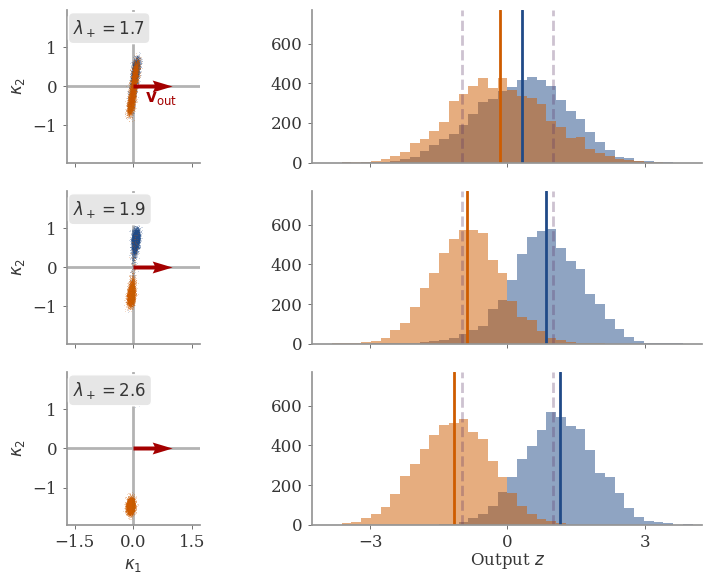

In [33]:
n_rows = n_lp_sim
n_cols = 2
fig = plt.figure(figsize=(4 * n_cols, 2 * n_rows))
axes = subplots(fig, n_rows, n_cols, sharex=False)
i_cos = [0, 1]
out_max = np.abs(output_sim).max()
for i_r in range(n_rows):
    i_c = 0
    ax = axes[i_r, i_c]

    i_lp = i_r
    lam_p = lam_ps_sim[i_lp]
    
    # Dots in space
    for i_tc in range(2):
        i_co = i_cos[i_tc]
        c = colors[i_co]
        kappa = kappa_sim[:, i_lp, i_tc::2].reshape((-1, rank))
        ax.plot(*kappa.T, '.', ms=1, markeredgewidth=0, c=c, alpha=0.3, )
    if sigma_noise == 1.0:
        ylim = 1.95
        xlim = 1.7#ylim/aspect
        ax.set_xticks([-1.5, 0, 1.5])
    elif sigma_noise == 0.2:
        ylim = 1.3
        xlim = 0.5
    ax.set_ylim(-ylim, ylim)
    ax.set_xlim(-xlim, xlim)
    ax.axhline(0, c=c_leg, zorder=-1)
    ax.axvline(0, c=c_leg, zorder=-1)
    ax.set_aspect("equal")
    if i_r == n_rows-1:
        ax.set_xlabel(r"$\kappa_1$")
    else:
        ax.set_xticklabels([])
    lbl = r"$\lambda_+ = %.1f$" % (lam_p)
    ylbl = lbl + "\n" + r"$\kappa_2$"
    ylbl = r"$\kappa_2$"
    ax.set_ylabel(ylbl)
    # Output weights
    wo_p = np.array([1, 0])
    ax.quiver(0, 0, *wo_p, scale=1, scale_units='xy',
              width=0.03, #headwidth=10, headlength=15, headaxislength=10,
              color=colors[3],
              zorder=3, 
             )
    if i_r == 0:
        ax.text(wo_p[0] - 0.3, wo_p[1] - 0.1, r"$\mathbf{v}_\mathrm{out}$", ha='center', va='top', c=colors[3])
        
    #######################################################################
    # Histogram of output
    i_c = 1
    ax = axes[i_r, i_c]
    i_out = 0
    outs = output_sim[:, i_lp]
    n_bins = 41
    bins = np.linspace(-out_max, out_max, n_bins)
    # Trial-conditioned averages
    for i_tc in range(2):
        i_co = i_cos[i_tc]
        c = colors[i_co]
        out_mean = outs[:, i_tc::2].mean()
        ax.axvline(out_mean, ls='-', c=c)
        ax.axvline((-1)**i_tc * z_target, ls='--', c=colors[4], alpha=0.3)
        ax.hist(outs[:, i_tc::2].flatten().numpy(), bins, linewidth=0, color=c, alpha=0.5)
    ticks = np.array([-3, 0, 3])
    ax.set_xticks(ticks)
    ax.set_xlim(-out_max, out_max)
    # ax.set_ylabel(r"Counts")
    if i_r == n_rows-1:
        ax.set_xlabel(r"Output $z$", labelpad=0)
    else:
        ax.set_xticklabels([])
    if sigma_noise == 1.0:
        ax.set_ylim(0, 770)
    elif sigma_noise == 0.2:
        ax.set_ylim(0, 920)
        
    
    ax = axes[i_r, 0]
    lbl = r"$\lambda_+ = %.1f$" % (lam_p)
    props = dict(boxstyle='round', facecolor='0.9', alpha=1.)
    ax.text(0.05, 0.95, lbl, ha='left', va='top', transform=ax.transAxes, bbox=props)
    
fig.tight_layout()

/tmp/ipykernel_260149/3926452385.py:114: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  out_max = np.abs(output_sim).max()


Save figure to ../figures/fig_12_fp_mft_erf.both


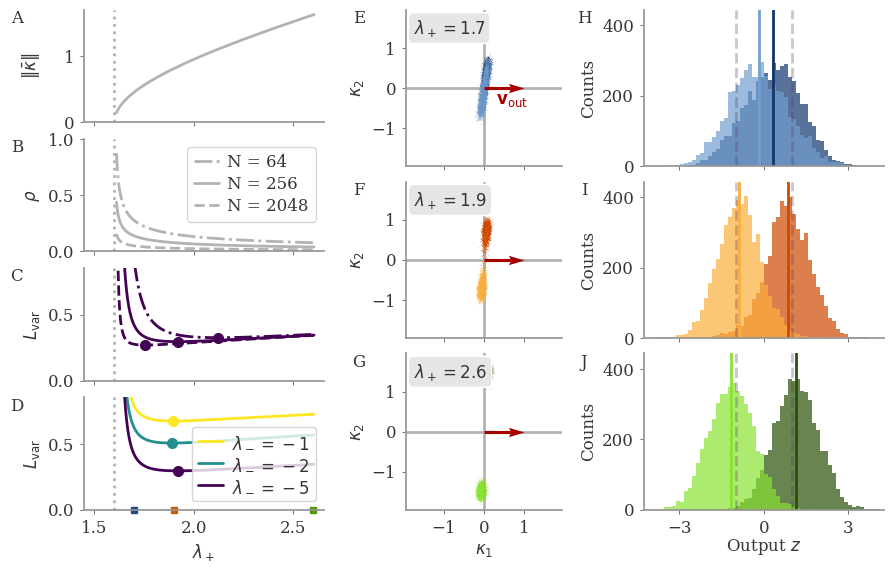

In [40]:
#### Joint figure
fig = plt.figure(figsize=(8, 5))

#  L_var
n_r_L = 4
n_c_L = 1
gs0 = GridSpec(n_r_L, n_c_L)
gs0.update(left=0., right=0.3, bottom=0., top=1., wspace=0., hspace=0.15)
axes_L = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_c_L)] for k in range(n_r_L)])
# Dots and histograms
n_rows = 3
n_r_dots = n_rows
n_c_dots = 1
gs0 = GridSpec(n_r_dots, n_c_dots)
gs0.update(left=0.4, right=0.6, bottom=0., top=1., wspace=0., hspace=0.1)
axes_dots = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_c_dots)] for k in range(n_r_dots)])
n_r_hist = n_rows
n_c_hist = 1
gs0 = GridSpec(n_r_hist, n_c_hist)
gs0.update(left=0.7, right=1., bottom=0., top=1., wspace=0., hspace=0.1)
axes_hist = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_c_hist)] for k in range(n_r_hist)])


############################################################################
### MFT
axes = axes_L
i_c = 0
### Kappa norm
i_r = 0
c = c_leg
ax = axes[i_r, i_c]
ax.plot(lam_ps, kappa_norms, c=c)
ax.set_ylabel(r"$\|\bar{\kappa}\|$")
ax.set_ylim(0)
### Correlation
i_r = 1
ax = axes[i_r, i_c]
N_shows = np.array([64, 256, 2048])
mss = ["-.", "-", "--"]
i_show = np.where(N_shows[:, None] == Ns)[1]
for i in range(len(i_show)):
    ms = mss[i]
    i_N = i_show[i]
    y = rhos[i_N]
    ax.plot(lam_ps, y, ms, c=c, label="N = %d" % Ns[i_N])
ax.set_ylabel(r"$\rho$")
ax.set_ylim(0, 1)
ax.legend(loc=1, 
          labelspacing=0.3, handlelength=1.5, markerscale=1., 
        handletextpad=0.5, columnspacing=0.5, )
### Loss
from helpers import color_iterator
n_lam_m = len(lam_ms)
c_iter = color_iterator(n_lam_m, "viridis_r")
cs_L = np.array([c_iter(i) for i in range(n_lam_m)])
### For different N
i_r = 2
ax = axes[i_r, i_c]
i_lam_m = np.where(lam_ms == lam_m_show)[0][0]
c = cs_L[i_lam_m]
N_shows = np.array([64, 256, 2048])
mss = ["-.", "-", "--"]
i_show = np.where(N_shows[:, None] == Ns)[1]
for i in range(len(i_show)):
    ms = mss[i]
    i_N = i_show[i]
    y = L_vars[i_N, i_lam_m]
    ax.plot(lam_ps, y, ms, c=c, label="N = %d" % Ns[i_N])
    i_min = np.argmin(y)
    ax.plot(lam_ps[i_min], y[i_min], 'o', ms=7, c=c)
### For different lam_m
i_r = 3
ax = axes[i_r, i_c]
i_N = np.where(N_show == Ns)[0][0]
for i, lam_m_i in enumerate(lam_ms):
    i_lam_m = i
    c = cs_L[i_lam_m]
    y = L_vars[i_N, i_lam_m]
    ax.plot(lam_ps, y, c=c, label=r"$\lambda_-= %d$" % lam_m_i)
    i_min = np.argmin(y)
    ax.plot(lam_ps[i_min], y[i_min], 'o', ms=7, c=c)
ax.legend(loc=4, 
          labelspacing=0.3, handlelength=1.5, markerscale=1., 
        handletextpad=0.5, columnspacing=0.5, )

# Polish
for i_r in range(n_r_L):
    ax = axes[i_r, i_c]
    ax.axvline(lam_p_min, ls=':', c=c_leg,
               label=r"$\lambda_{+, \mathrm{min}}$" if i_r == 0 else None)
    ax.set_xlim(1.45, )
    
    if i_r in [2, 3]:
        ymax = L_vars[..., -1].max()*1.17
        ax.set_ylim(0, ymax)
        ax.set_ylabel(r"$L_\mathrm{var}$")
    
    if i_r == n_r_L-1:
        ax.set_xlabel(r"$\lambda_+$")
    else:
        ax.set_xticklabels([])
# Indicate the parameters for the second half
ax = axes_L[-1, 0]
for i in range(n_lp_sim):
    ax.plot(lam_ps_sim[i], 0, 's', ms=5, c=colors[i], clip_on=False)
    
############################################################################
### Dots and histograms
i_cos = [0, 2]
i_c = 0
out_max = np.abs(output_sim).max()
h_o_max = 0
for i_r in range(n_rows):
    i_lp = i_r
    lam_p = lam_ps_sim[i_lp]
    
    #######################################################################
    # Dots in space
    ax = axes_dots[i_r, i_c]
    for i_tc in range(2):
        i_co = i_cos[i_tc]
        c = cs[i_r, i_co]
        # c = colors[i_co]
        kappa = kappa_sim[i_s, i_lp, i_tc::2]
        ax.plot(*kappa.T, '.', ms=1, markeredgewidth=0, c=c, alpha=0.3, )
    if sigma_noise == 1.0:
        ylim = 1.95
        xlim = ylim#ylim/aspect
        ax.set_xticks([-1, 0, 1])
    elif sigma_noise == 0.2:
        ylim = 1.3
        xlim = 0.5
    ax.set_ylim(-ylim, ylim)
    ax.set_xlim(-xlim, xlim)
    ax.axhline(0, c=c_leg, zorder=-1)
    ax.axvline(0, c=c_leg, zorder=-1)
    ax.set_aspect("equal")
    if i_r == n_rows-1:
        ax.set_xlabel(r"$\kappa_1$")
    else:
        ax.set_xticklabels([])
    lbl = r"$\lambda_+ = %.1f$" % (lam_p)
    ylbl = lbl + "\n" + r"$\kappa_2$"
    ylbl = r"$\kappa_2$"
    ax.set_ylabel(ylbl)
    # Output weights
    wo_p = np.array([1, 0])
    ax.quiver(0, 0, *wo_p, scale=1, scale_units='xy',
              width=0.02, #headwidth=10, headlength=15, headaxislength=10,
              color=colors[3],
              zorder=3, 
             )
    if i_r == 0:
        ax.text(wo_p[0] - 0.3, wo_p[1] - 0.1, r"$\mathbf{v}_\mathrm{out}$", fontsize=fs, ha='center', va='top', c=colors[3])
        
    #######################################################################
    # Histogram of output
    ax = axes_hist[i_r, i_c]
    i_out = 0
    bins = np.linspace(-out_max, out_max, 61)
    # Trial-conditioned averages
    for i_tc in range(2):
        i_co = i_cos[i_tc]
        # c = colors[i_co]
        c = cs[i_r, i_co]
        y = output_sim[i_s, i_lp, i_tc::2]
        ax.axvline(y.mean(), ls='-', c=c)
        ax.axvline((-1)**i_tc * z_target, ls='--', c=colors[4], alpha=0.3,)
        h_o, _, _ = ax.hist(y.flatten().numpy(), bins, linewidth=0, color=c, alpha=0.7)
        h_o_max = max(h_o_max, h_o.max())
    ticks = np.array([-3, 0, 3])
    ax.set_xticks(ticks)
    ax.set_xlim(-out_max, out_max)
    ax.set_ylabel(r"Counts")
    if i_r == n_rows-1:
        ax.set_xlabel(r"Output $z$", labelpad=0)
    else:
        ax.set_xticklabels([])
        
for i_r in range(n_rows):
    ax = axes_hist[i_r, 0]
    ax.set_ylim(0, h_o_max*1.1)
        
    
    ax = axes_dots[i_r, 0]
    i_lp = i_r
    lam_p = lam_ps_sim[i_lp]
    lbl = r"$\lambda_+ = %.1f$" % (lam_p)
    props = dict(boxstyle='round', facecolor='0.9', alpha=1.)
    ax.text(0.05, 0.95, lbl, ha='left', va='top', fontsize=fs, transform=ax.transAxes, bbox=props)
    
fig.align_labels(axes_L)
fig.align_labels(axes_hist)
    
# Label plots
for i in range(len(fig.axes)):
    ax = fig.axes[i]
    if i < n_r_L:
        xpos = -0.28
    elif i < n_r_L+3:
        xpos = -0.30
    else:
        xpos = -0.25
    ypos = 1.0
    ax.text(xpos, ypos, flbs[i], fontsize=fs, ha='center', va='top', transform=ax.transAxes)

fig_name = ("fig_12_fp_mft_erf").replace('.', '_')
saving_fig(fig, figure_path, fig_name, data_type='both')